In [3]:
import os
import pandas as pd
import cv2
import tensorflow.python.keras as keras
import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from skimage import io
data_dir = 'GTSRB/Training'

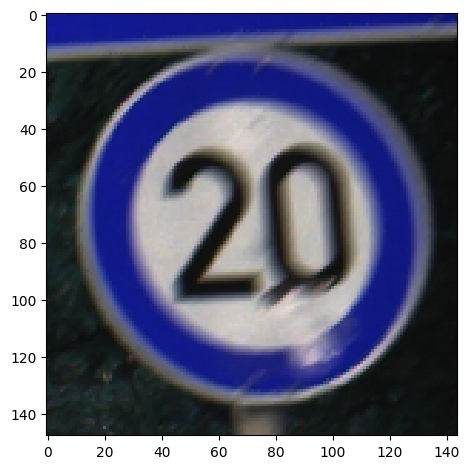

In [4]:
img = cv2.imread('GTSRB/Training/00000/00000_00029.ppm')
io.imshow(img)

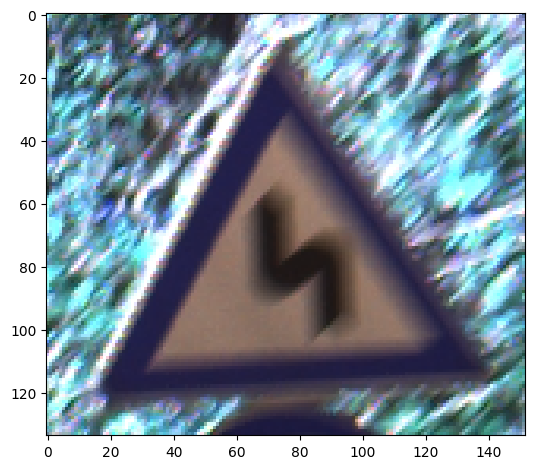

In [6]:
img = cv2.imread('GTSRB/Training/00021/00000_00029.ppm')
io.imshow(img)

In [100]:
def preprocess(img):
    return cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

In [172]:
list_images = []
output = []

for dir in os.listdir(data_dir):
    i = 0
    if dir == '.DS_Store' :
        continue
    inner_dir = os.path.join(data_dir, dir)
    csv_file = pd.read_csv(os.path.join(inner_dir,"GT-" + dir + '.csv'), sep=';')
    for row in csv_file.iterrows():
        if i < 100:
            img_path = os.path.join(inner_dir, row[1].Filename)
            img = cv2.imread(img_path)
            img = img[row[1]['Roi.X1']:row[1]['Roi.X2'],row[1]['Roi.Y1']:row[1]['Roi.Y2'],:]
            img = preprocess(img)
            list_images.append(img)
            output.append(row[1].ClassId)
        i += 1
print(len(list_images))

4300


In [177]:
input_array = np.stack(list_images)
train_y = to_categorical(output)

randomize = np.arange(len(input_array))
np.random.shuffle(randomize)

x = input_array[randomize]
y = train_y[randomize]

In [178]:
split_size = int(x.shape[0]*0.6)
train_x, val_x = x[:split_size], x[split_size:]
train1_y, val_y = y[:split_size], y[split_size:]
print(train_x.shape, val_x.shape)
print(train1_y.shape, val_y.shape)
split_size = int(val_x.shape[0]*0.5)
val_x, test_x = val_x[:split_size], val_x[split_size:]
val_y, test_y = val_y[:split_size], val_y[split_size:]
print(val_x.shape, test_x.shape)
print(val_y.shape, test_y.shape)

(2580, 64, 64, 3) (1720, 64, 64, 3)
(2580, 43) (1720, 43)
(860, 64, 64, 3) (860, 64, 64, 3)
(860, 43) (860, 43)


In [179]:
epochs = 10
batch_size = 16

input_shape = Input(shape=(32, 32,3))

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64,64,3), padding='same'),
    BatchNormalization(),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(units=2048, activation='relu'),
    Dropout(0.2),
    Dense(units=1024, activation='relu'),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=43, input_dim=2048, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
trained_model_conv = model.fit(train_x.reshape(-1,64,64,3), train1_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y))

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.0481 - loss: 4.0485 - val_accuracy: 0.1442 - val_loss: 3.4168
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.1957 - loss: 3.1593 - val_accuracy: 0.3895 - val_loss: 2.4405
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.3270 - loss: 2.5098 - val_accuracy: 0.6186 - val_loss: 1.4873
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5404 - loss: 1.6971 - val_accuracy: 0.7581 - val_loss: 0.9142
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6739 - loss: 1.1486 - val_accuracy: 0.8500 - val_loss: 0.5521
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7761 - loss: 0.7852 - val_accuracy: 0.9174 - val_loss: 0.3510
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8394 - loss: 0.5380 - val_accuracy: 0.9384 - val_loss: 0.2510
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9077 - loss: 0.3447 - 

In [180]:
model.evaluate(test_x, test_y)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9718 - loss: 0.0994


[0.10003896802663803, 0.9720930457115173]